# Imports

In [1]:
from PIL import Image # import Pillow
import numpy as np
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

$$ \frac{dx}{dt} = 5x - 3 $$
$$ \text{IC: }x(2) = 1 $$
$$ x(t) = \frac{2}{5} e^{5(t-2)} + \frac{3}{5} $$
$$ \text{BC: }x(0) = 0.6, x(2) = 1 $$

# Custom Functions and Equation Setup

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    """
    Helper function for saving GIFs.
    """
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format="GIF", append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [3]:
def analytical(t):
    """
    Defines the analytical solution to the example equation.
    """
    exp = math.e**(5 * (t - 2))
    y = 2/5 * exp + 3/5
    return y

In [4]:
class FCN(nn.Module):
    """
    Defines a fully connected neural network.
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                        nn.Linear(N_HIDDEN, N_HIDDEN),
                        activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Creating Training Data

In [38]:
# generate the full analytical solution
x = torch.linspace(0,2,500).view(-1,1)
y = analytical(x).view(-1,1)

# extract every 20th point from the analytical solution
x_data = x[0:400:10]
y_data = y[0:400:10]

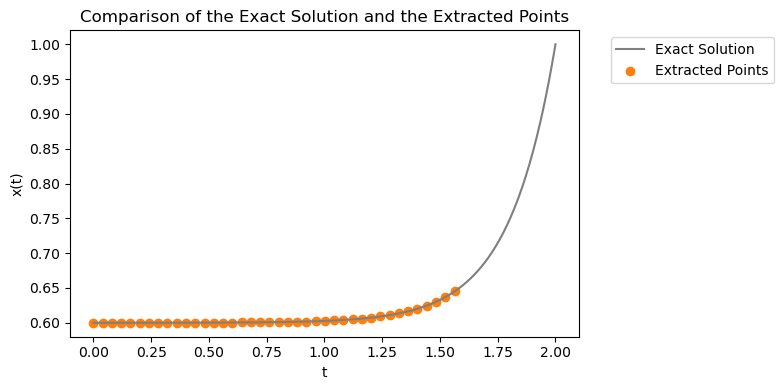

In [39]:
# visualize the data extraction
plt.figure(figsize=(8,4))
plt.title("Comparison of the Exact Solution and the Extracted Points")
plt.ylabel("x(t)")
plt.xlabel("t")
plt.plot(x, y, label="Exact Solution", color="tab:gray")
plt.scatter(x_data, y_data, color="tab:orange", label="Extracted Points")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# saving the file to /images
plt.tight_layout()
# filename = "ExampleOne-TrainingData"
# filepath = f"../images/{filename}.png"
# plt.savefig(f"{filepath}")
plt.show()

# Training and Visualizing Model Performance

In [60]:
def plot_result(x, y, x_data, y_data, yh, tag, color="tab:red"):
    """
    Plot given model's performance. Title the plot with the given tag argument.
    """
    plt.figure(figsize=(8,4))
    plt.title(f"{tag} Modeling Performance")
    plt.ylabel("x(t)")
    plt.xlabel("t")
    plt.plot(x, y, color="tab:gray", linewidth=2, alpha=0.8, label="Exact Solution")
    plt.plot(x, yh, color=color, linewidth=4, alpha=0.8, label=f"{tag} Prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label="Training Data")
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 2.05)
    plt.ylim(0.59, 1.01)
    plt.text(2.1, .9, "Training step: {:05d}".format(i+1), fontsize="xx-large", color="k")

In [61]:
random_seed = 123 # set random seed for modeling

### Traditional NN

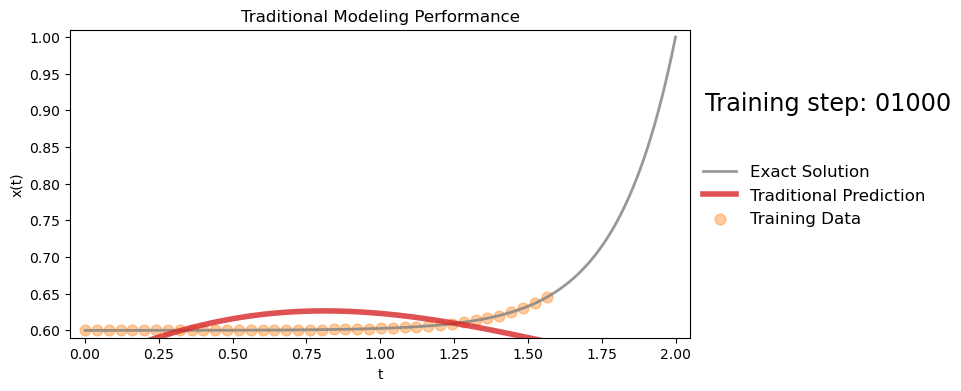

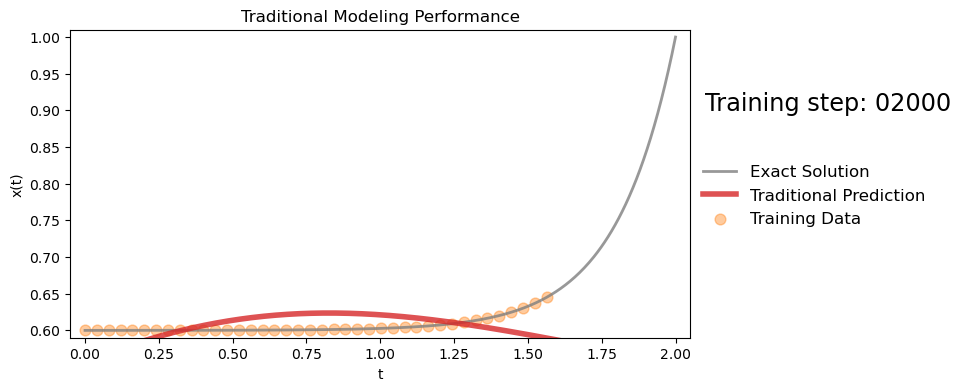

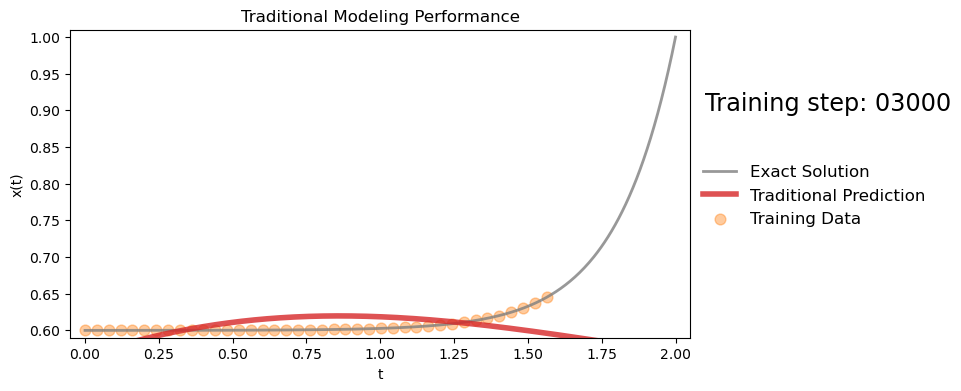

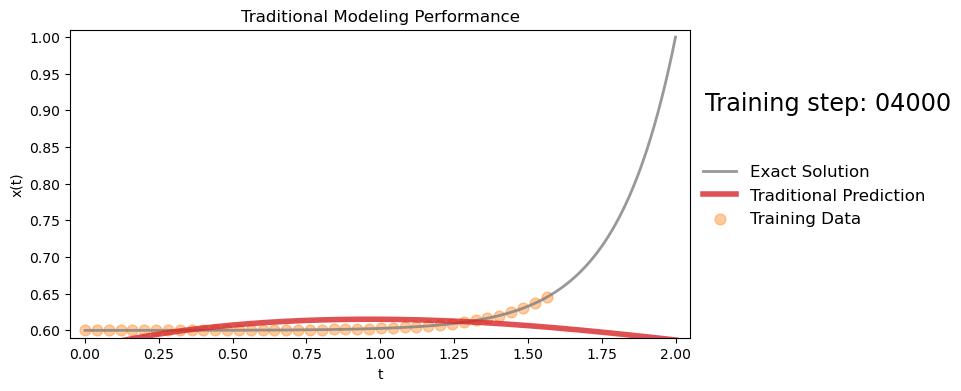

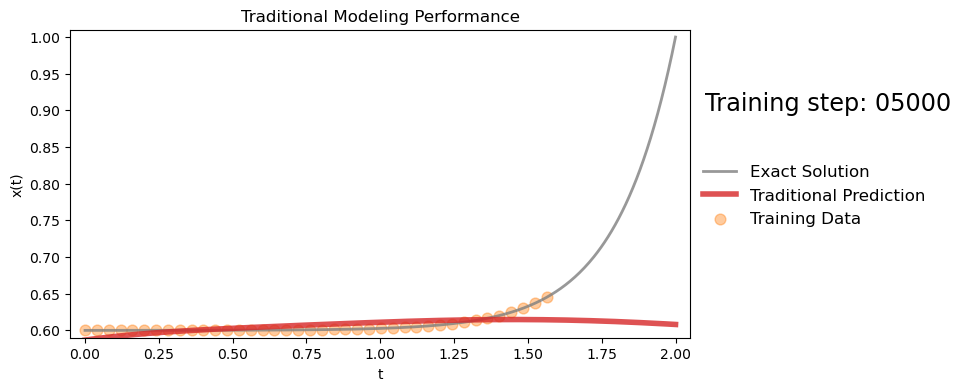

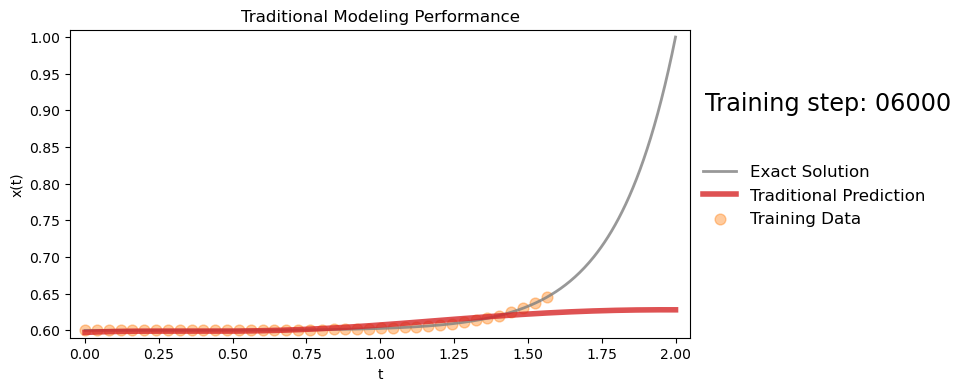

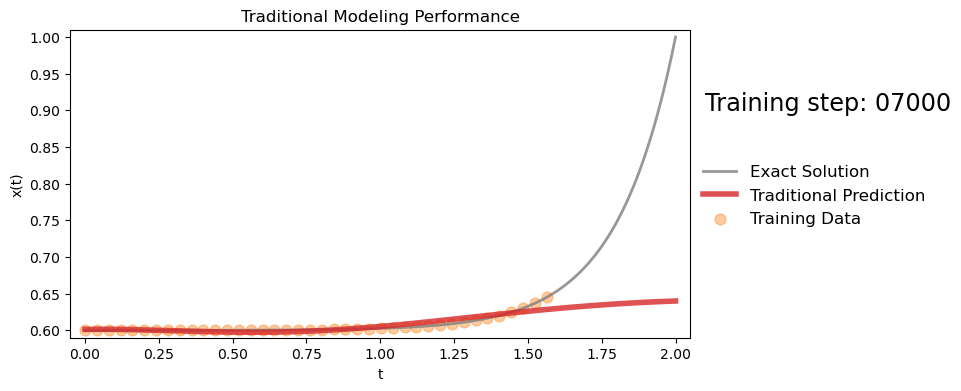

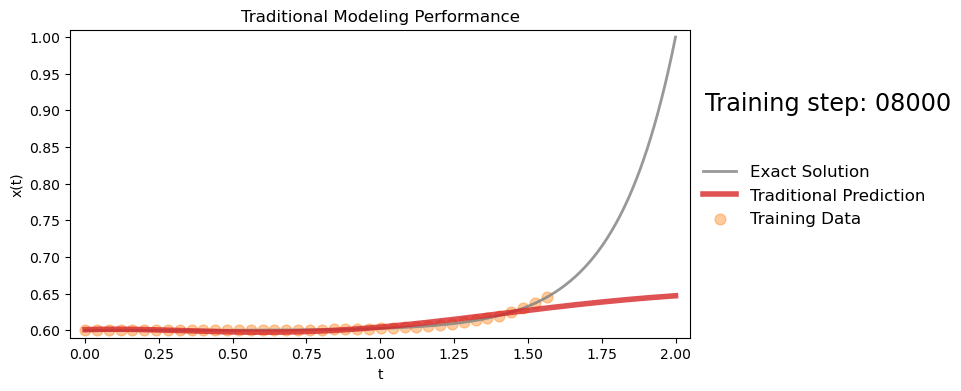

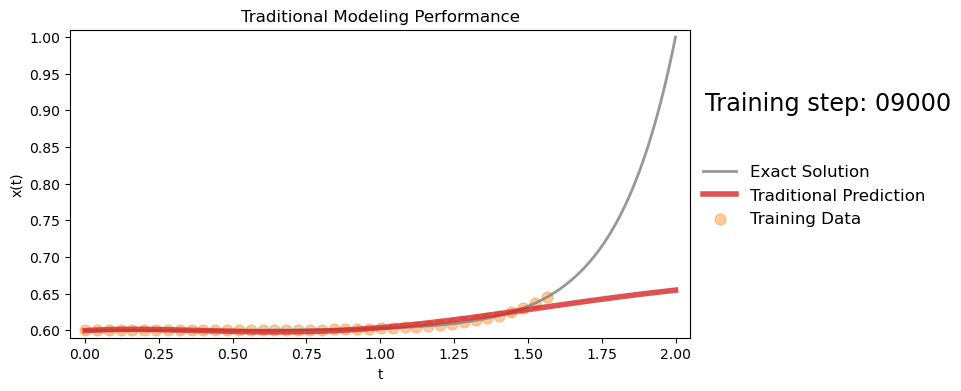

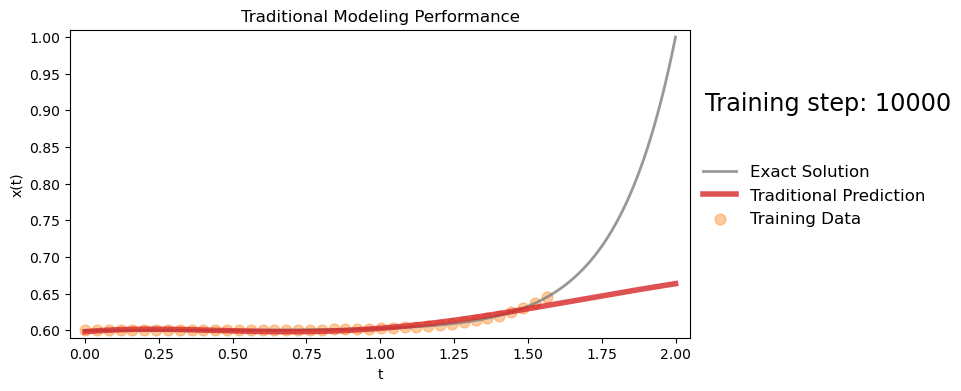

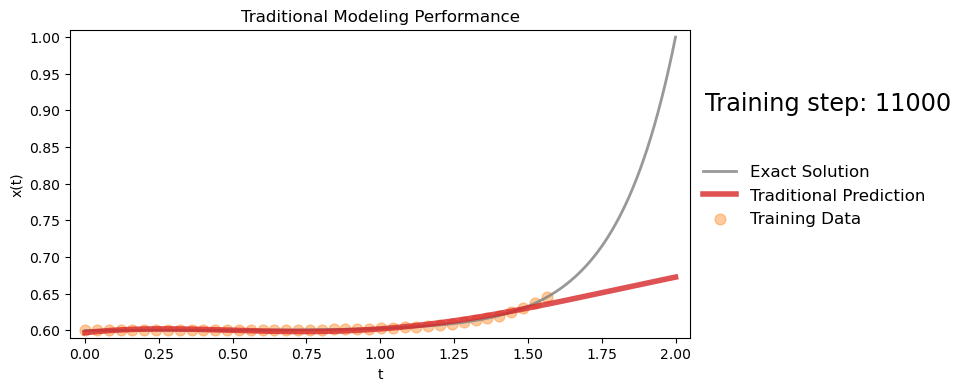

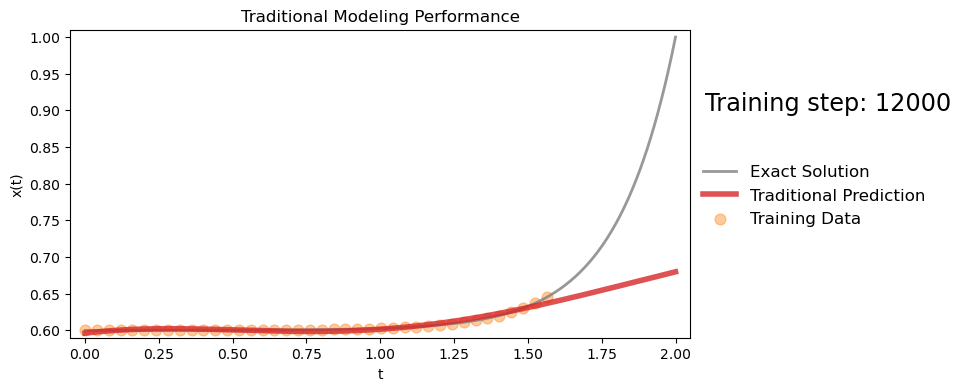

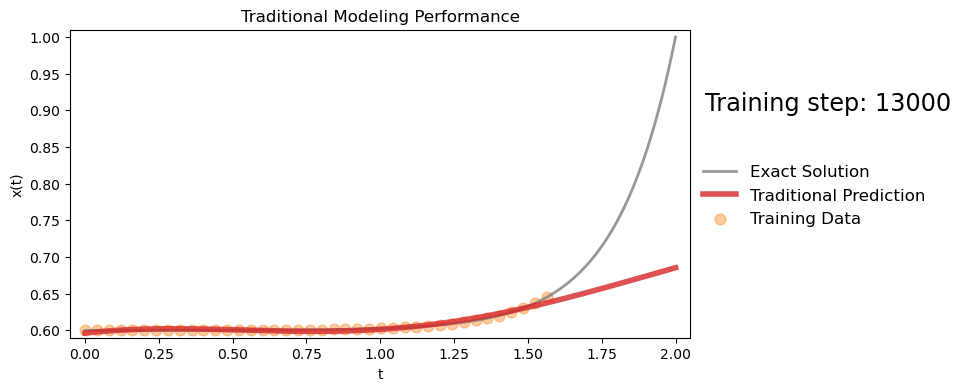

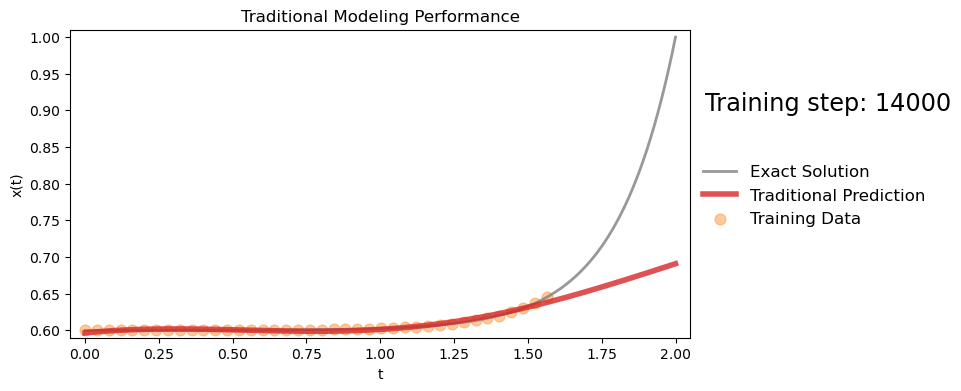

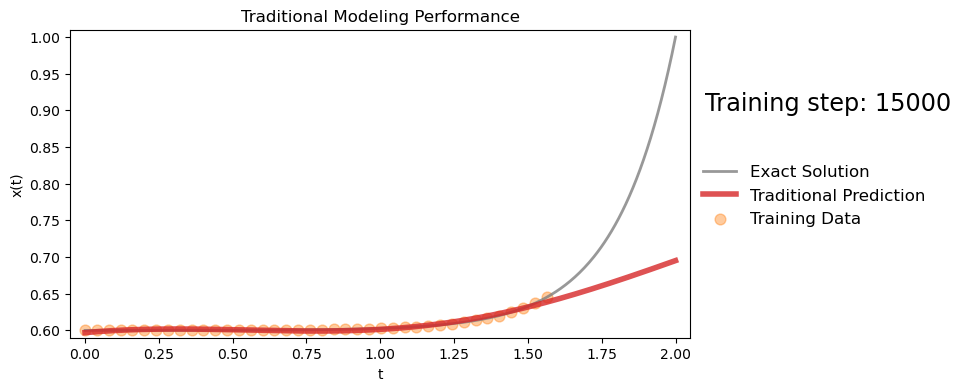

In [68]:
tag = "Traditional" # label graphs as traditional
nn_errors = []  # store NN errors
files = [] # store gif images

# create and setup traditional model
torch.manual_seed(random_seed)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

for i in range(15000):
    # forward and backward pass on training data
    optimizer.zero_grad()
    y_nn = model(x_data)
    train_loss = torch.mean((y_nn - y_data)**2) # use mean squared error
    train_loss.backward()
    optimizer.step()

    # calculate actual loss
    y_nn = model(x).detach()
    actual_loss = torch.mean((y_nn - y)**2)
    nn_errors.append(actual_loss.item())
    
    # plot the result as training progresses
    if (i+1) % 250 == 0: 
        plot_result(x, y, x_data, y_data, y_nn, tag)
        filepath = "trad-plot/nn_%.8i.png"%(i+1)
        files.append(filepath)
        plt.savefig(filepath, bbox_inches="tight", pad_inches=0.2, dpi=100, facecolor="white")

        if (i+1) % 1000 == 0:
            plt.show()
        else: 
            plt.close("all")

# create GIF
filepath = "../images/Example-One-NN.gif"
save_gif_PIL(filepath, files, fps=20, loop=0)

### PINNs

In [69]:
t_physics = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True) # sample locations over the problem domain
x0 = 1  # initial condition, x(0) = 1
mu = 5  # coefficient
c = -3  # constant
# dx/dt = mu*x + c
# dx/dt = 5x - 3

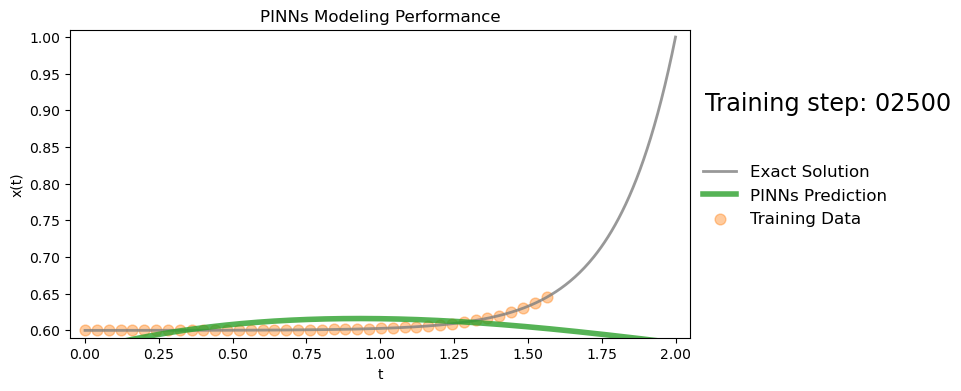

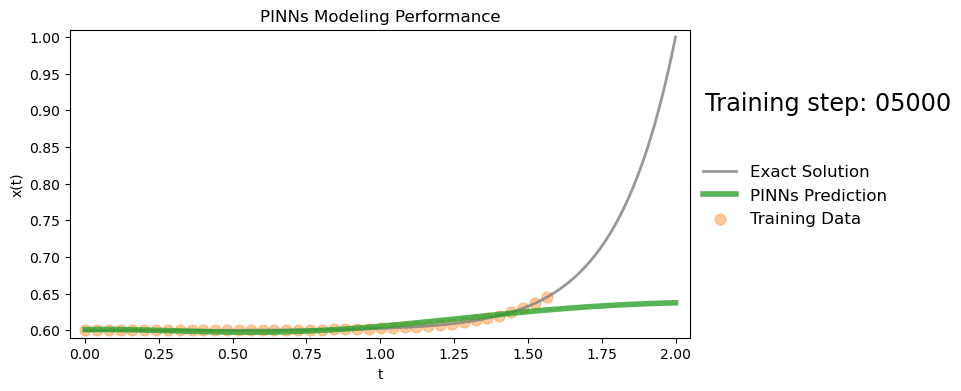

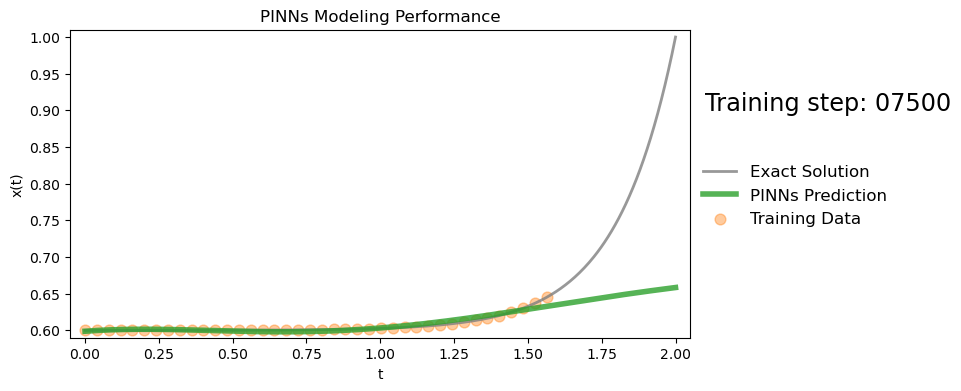

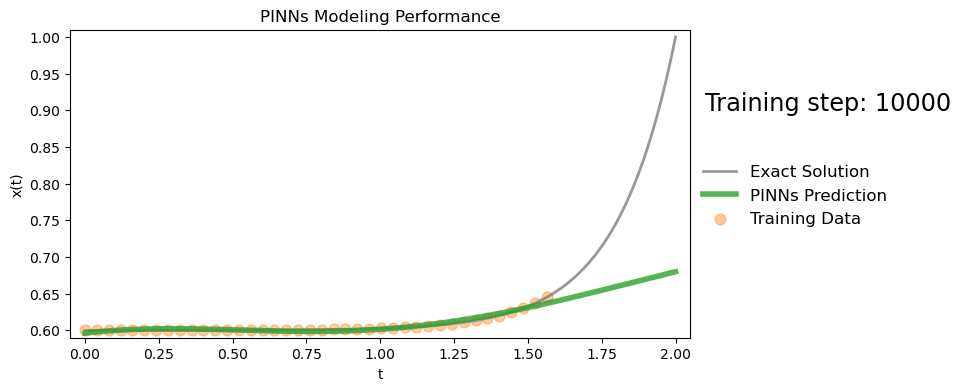

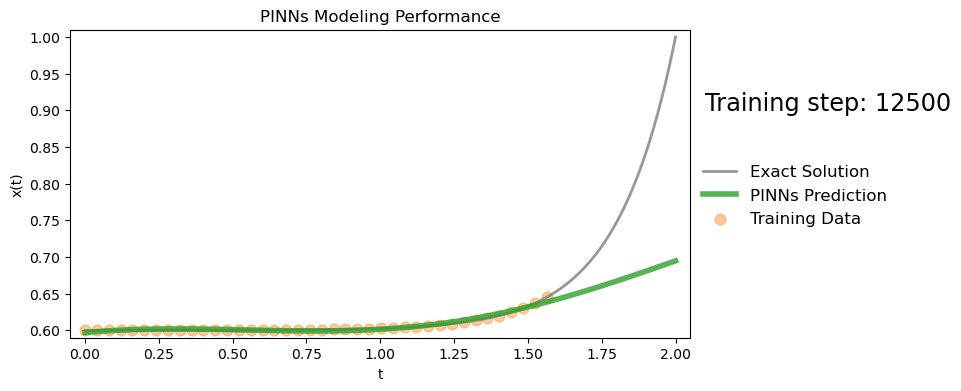

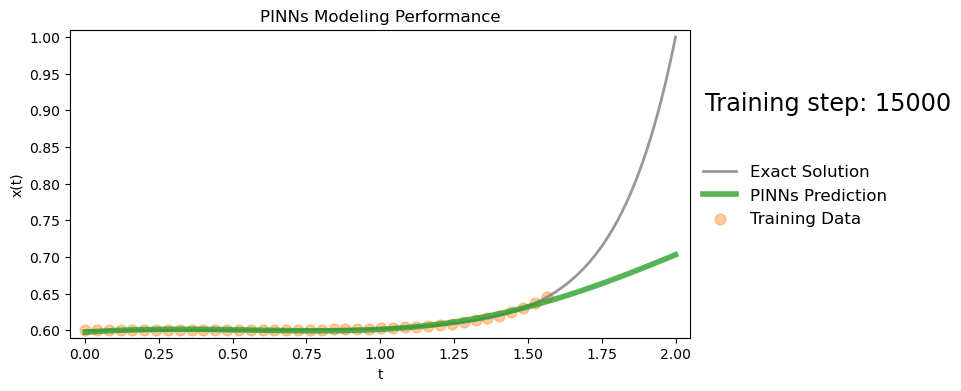

KeyboardInterrupt: 

In [77]:
tag = "PINNs" # label graphs as PINNs
pinn_errors = [] # store PINN errors 
files = [] # store gif images

# create and setup PINN model
torch.manual_seed(random_seed)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=9e-5)

for i in range(90000):
    # compute the "data loss" from the training data
    optimizer.zero_grad()
    y_pinn = model(x_data)
    loss1 = torch.mean((y_pinn-y_data)**2) # use mean squared error
    
    # compute the "physics loss" from ODE
    x_predicted = model(t_physics)
    dx_dt = torch.autograd.grad(x_predicted, t_physics, torch.ones_like(x_predicted), create_graph=True)[0] # computes dx/dt
    ode_residual = dx_dt - (mu * x_predicted + c)  # Residual of the differential equation
    loss2 = torch.mean(ode_residual**2)
    
    # Scale the losses to balance their contributions
    data_loss_weight = 1.0
    physics_loss_weight = 1.0

    # Combine the losses with their respective weights
    combined_loss = data_loss_weight * loss1 + physics_loss_weight * loss2

    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()

    # calculate actual loss
    y_pinn = model(x).detach()
    actual_loss = torch.mean((y_pinn - y)**2)
    pinn_errors.append(actual_loss.item())
    
    # plot the result as training progresses
    if (i+1) % 500 == 0:
        plot_result(x, y, x_data, y_data, y_pinn, tag, color="tab:green")
        filepath = "pinns-plot/pinn_%.8i.png"%(i+1)
        files.append(filepath)
        plt.savefig(filepath, bbox_inches="tight", pad_inches=0.2, dpi=100, facecolor="white")

        if (i+1) % 2500 == 0:
            plt.show()
        else: 
            plt.close("all")

# create GIF
filepath = "../images/Example-One-TEST-PINN.gif"
save_gif_PIL(filepath, files, fps=20, loop=0)

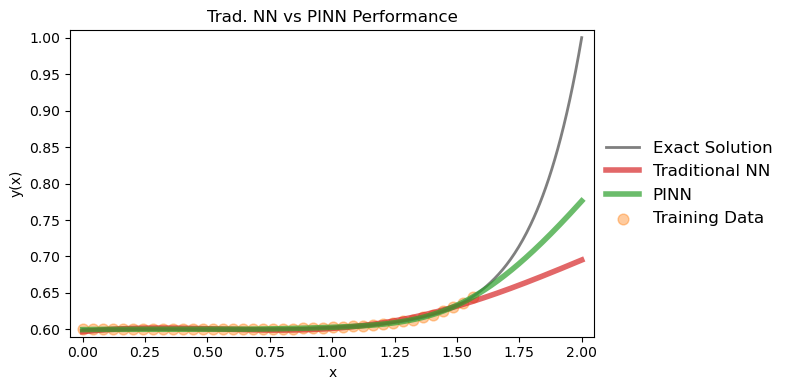

In [74]:
# Plotting Comparison
plt.figure(figsize=(8,4))
plt.title(f"Trad. NN vs PINN Performance")
plt.ylabel("y(x)")
plt.xlabel("x")
plt.plot(x, y, color="tab:gray", linewidth=2, alpha=1, label="Exact Solution")
plt.plot(x, y_nn, color="tab:red", linewidth=4, alpha=0.7, label="Traditional NN")
plt.plot(x, y_pinn, color="tab:green", linewidth=4, alpha=0.7, label="PINN")
plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label="Training Data")
l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
plt.setp(l.get_texts(), color="k")

plt.xlim(-0.05, 2.05)
plt.ylim(0.59, 1.01)
plt.tight_layout()
filename = "Example-One-FinalComparison"
plt.savefig(f"../images/{filename}.png")
plt.show()

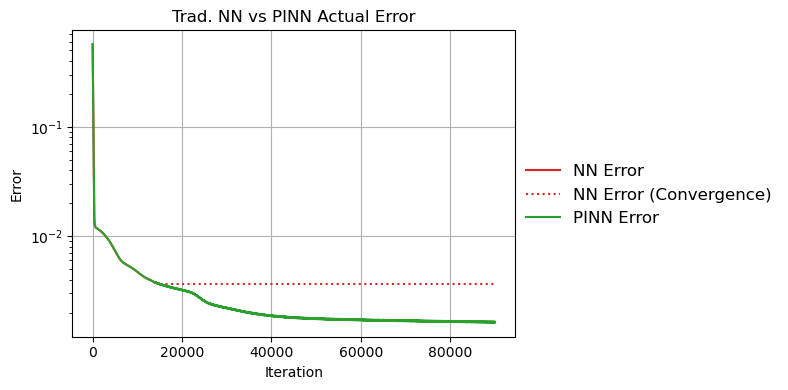

In [76]:
# Plotting errors
plt.figure(figsize=(8,4))
plt.title(f"Trad. NN vs PINN Actual Error")
plt.ylabel("Error")
plt.xlabel("Iteration")
plt.yscale("log")
plt.grid(True)
plt.plot(range(1, len(nn_errors) + 1), nn_errors, color="tab:red", label="NN Error")
plt.hlines(nn_errors[-1], len(nn_errors) + 1, len(pinn_errors) + 1, colors="tab:red", linestyles="dotted", label="NN Error (Convergence)")
plt.plot(range(1, len(pinn_errors) + 1), pinn_errors, color="tab:green", label="PINN Error")
l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
plt.tight_layout()
filename = "Example-One-ErrorComparison"
plt.savefig(f"../images/{filename}.png")
plt.show()